In [18]:
from vedo import *
import cv2
import numpy as np
import glob
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plyfile import PlyData, PlyElement
import pickle

In [34]:
fn_img = glob.glob("ML/output*/")
fn_img.sort()
imgall=[]

for fn in fn_img:
    #import image with depth
    image = np.load(fn+'stats.npy')
    imageD=image.reshape(1242, 2208, 5)[:,:,0]
    #imageD-=np.min(imageD)
    #imageD/=np.max(imageD)
    #imageD=imageD*255
    image = cv2.imread(fn+'imgL.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.dstack([image,imageD])
    image=image
    imgall.append(image)
maskall=[]
mask01=[]
i=0
for fn in fn_img[:13]:
    #mask
    #print(fn+f'TF_mask{i:02}.npy')
    mask=np.load(fn+f'TF_mask{i:02}.npy')
    i+=1
    maskall.append(mask)
    mt=mask.copy()
    mt[mt>0]=1
    mask01.append(mt.astype('uint8'))

fn_msk = glob.glob("ML/napari/*_napari.npz")
fn_msk.sort()
for fn in fn_msk[2:]:
    #import image with depth
    #print(fn)
    mask=np.load(fn)
    maskall.append(mask['arr_0'])
    mt=mask['arr_0'].copy()
    mt[mt>0]=1
    mask01.append(mt.astype('uint8'))

In [19]:
with open(fn_img[0]+'mask_sam.pickle', 'rb') as handle:
    SAMmasks = pickle.load(handle)

In [21]:
pebble_list=[]
i=0
for sg in SAMmasks:
    masked_counting = np.where(sg['segmentation'], maskall[i], 0)
    segment_size = np.count_nonzero(sg['segmentation'])
    non_zero_unique_values = np.unique(masked_counting[np.nonzero(masked_counting)], return_counts=True)
    k=0
    if len(non_zero_unique_values[0])==1:
        if (np.unique(maskall[i][maskall[i]==non_zero_unique_values[0][0]], return_counts=True)[1][0]/non_zero_unique_values[1][0])>2:
            k=0    
        elif (non_zero_unique_values[1][0]/segment_size)>=0.7:
            pebble_list.append(sg['segmentation'])

        

    elif len(non_zero_unique_values[0])>1:
        #sorting by count
        sort=np.argsort(non_zero_unique_values[1])
        #for id in sort:
        id=sort[-1]
        if non_zero_unique_values[1][id]>=100:
            if (np.unique(maskall[i][maskall[i]==non_zero_unique_values[0][id]], return_counts=True)[1][0]/non_zero_unique_values[1][id])>2:
                k=0
            elif (non_zero_unique_values[1][id]/segment_size)>=0.7:
                pebble_list.append(sg['segmentation'])

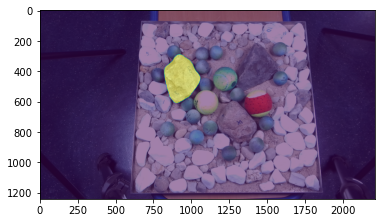

In [25]:
plt.imshow(imgall[0][:,:,:3])
plt.imshow(pebble_list[0], alpha=0.5)

In [35]:
rgb_image = imgall[0][:,:,:3]
depth_map = imgall[0][:,:,3]

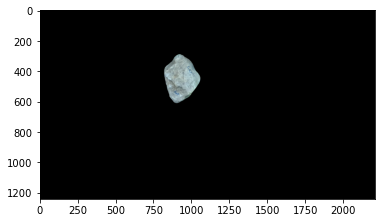

In [26]:
masked_image = np.copy(rgb_image)
masked_image[pebble_list[0] == 0] = 0

plt.imshow(masked_image)
plt.show()


In [36]:
rgb_image[pebble_list[0] == 0] = 0
depth_map[pebble_list[0] == 0] = 0

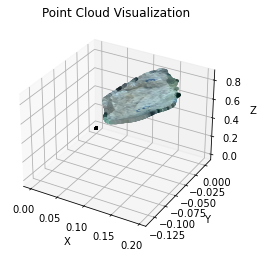

True

In [37]:
def create_point_cloud(rgb_image, depth_map, fx, fy, cx, cy):
    # Generate grid of pixel coordinates
    rows, cols = depth_map.shape
    c, r = np.meshgrid(np.arange(cols), np.arange(rows), sparse=True)
    
    # Generate 3D points
    z = depth_map
    x = (c - cx) * z / fx
    y = (r - cy) * z / fy
    
    # Flatten the points
    points = np.stack((x.flatten(), y.flatten(), z.flatten()), axis=-1)
    
    # Get colors from RGB image
    colors = rgb_image.reshape(-1, 3)
    
    return points, colors

# Example RGB image and depth map (replace these with your numpy arrays)

# Camera intrinsic parameters (replace with your actual camera parameters)
fx=1911.7869873046875
fy=1911.7869873046875
#cx=297.493
#cy=243.168
cx=600
cy=600

# Create point cloud
points, colors = create_point_cloud(rgb_image, depth_map, fx, fy, cx, cy)

# Visualize point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors / 255.0, marker='.')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Point Cloud Visualization')
plt.show()

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors / 255.0)  # Normalize colors to range [0, 1]

# Save point cloud to PLY file
o3d.io.write_point_cloud("point_cloud.ply", pcd)

In [3]:
pcd = o3d.io.read_point_cloud("output/pcd/pc_000img.pcd")
o3d.visualization.draw_geometries_with_editing([pcd])

In [4]:
pcd = o3d.io.read_point_cloud("output/normal/normal_000img.pcd")
o3d.visualization.draw_geometries_with_editing([pcd])

In [5]:
pcd = o3d.io.read_point_cloud("cvpc.ply")
o3d.visualization.draw_geometries_with_editing([pcd])

[Open3D WARNING] Read PLY failed: unable to read file: cvpc.ply


In [27]:
pcd = o3d.io.read_point_cloud("fpc2.ply")
o3d.visualization.draw_geometries_with_editing([pcd])

In [26]:
pcd = o3d.io.read_triangle_mesh("fpc2.obj", True)
#pcd.compute_vertex_normals()
o3d.visualization.draw_geometries_with_editing([pcd])

[Open3D WARNING] Unable to load file fpc2.obj with ASSIMP


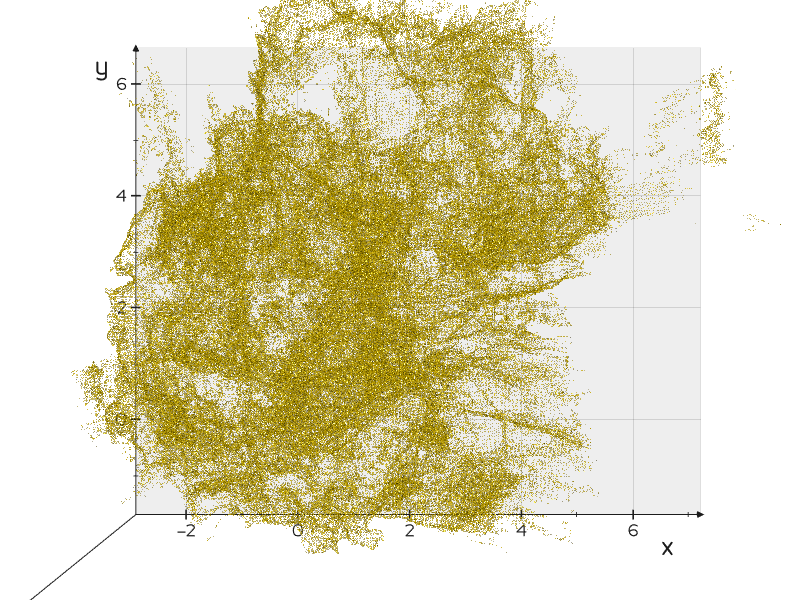

In [24]:
mesh = Mesh("fpc2.obj")
mesh.lighting('glossy')
mesh.show(axes=1)

<Mesh(0x000002272D982500) at 0x0000022736CD9FA0>
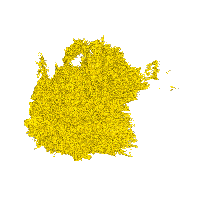

In [15]:
mesh